<a href="https://colab.research.google.com/github/hakim3189/MachineLearning/blob/main/Submission_Akhir_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Animal Faces
- **Nama:** Muhammad Rheza Iwanul Hakim
- **Email:** rheza.hakim.89@gmail.com
- **ID Dicoding:** rheza89

## Import Semua Packages/Library yang Digunakan

In [1]:
# Most Used Library
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
# Libraries for Image Processing
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import matplotlib.pyplot as plt
import seaborn as sns # This line imports the seaborn library and assigns it to the alias 'sns'
# Libraries for Build Model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau


import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhezahakim","key":"7d59da0af5d9999d1abcb09deec1950d"}'}

In [4]:
!kaggle datasets download -d andrewmvd/animal-faces
!unzip animal-faces.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train

In [5]:
import os
import shutil

In [6]:
# Direktori awal untuk train dan test
train_dir = "afhq/train"
test_dir = "afhq/val"

# Direktori baru untuk dataset gabungan
combined_dir = "afhq/dataset"

In [7]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [8]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

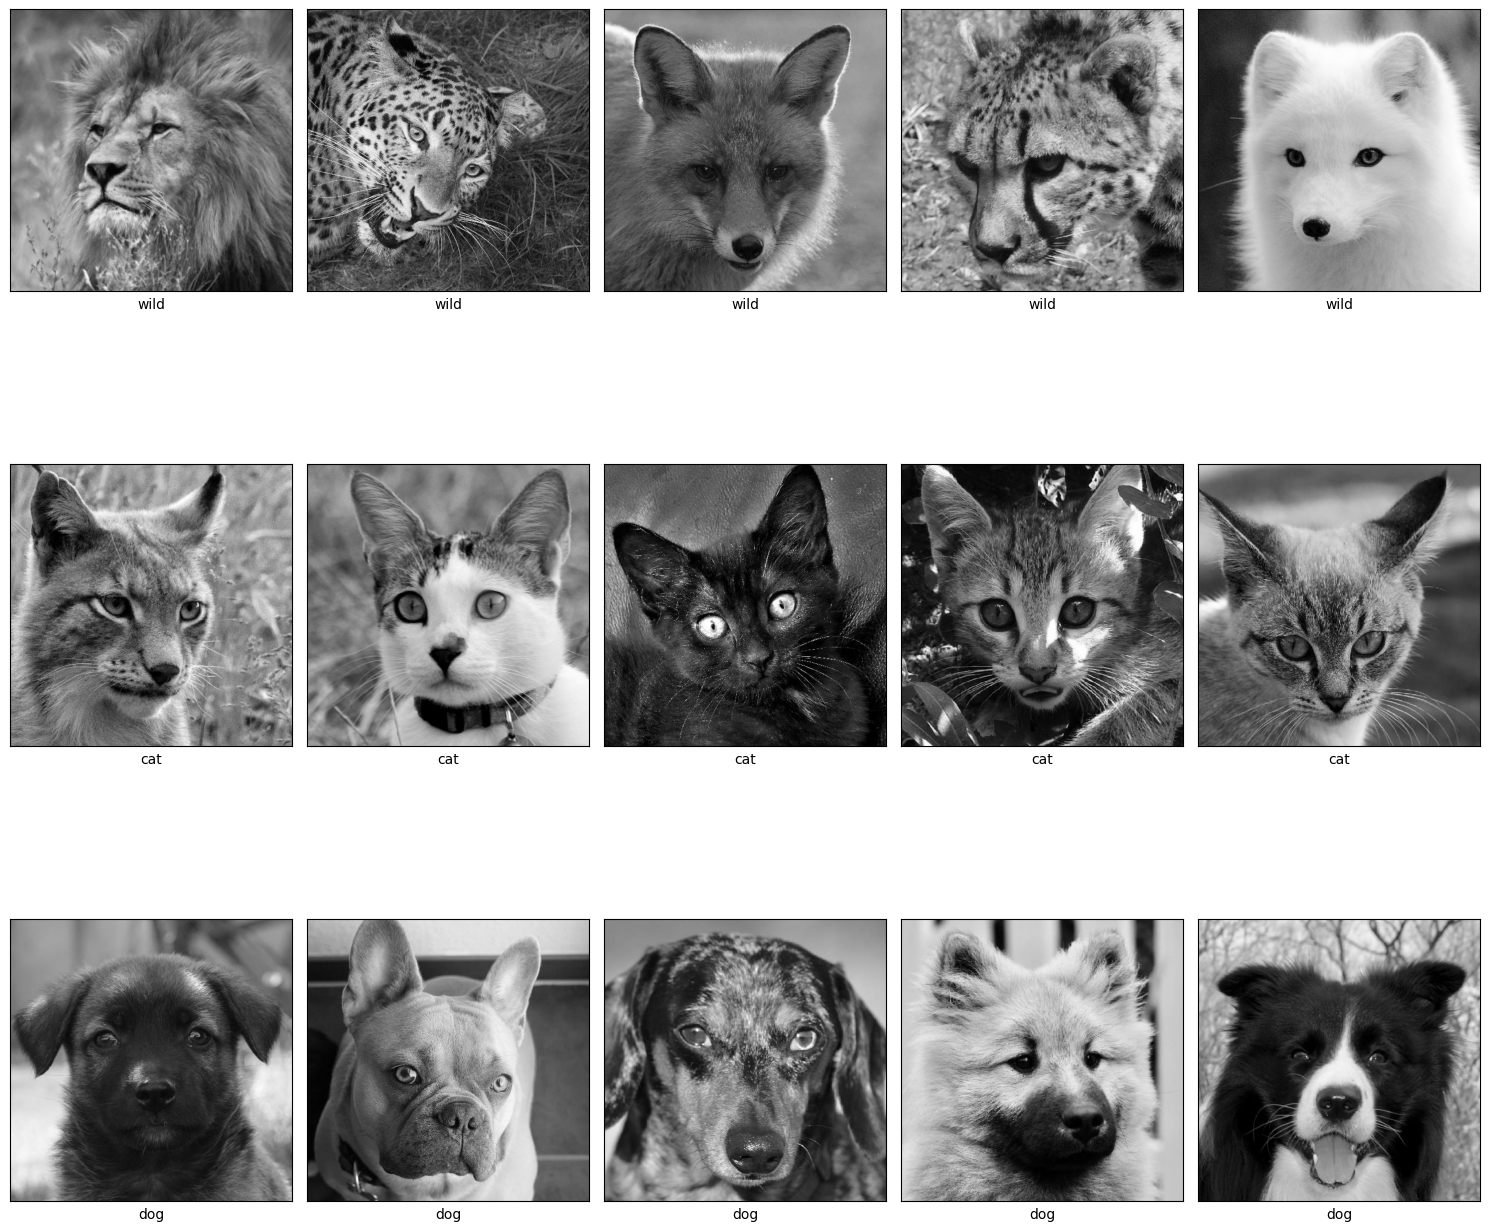

In [9]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
animal_faces_image = {}

# Tentukan path sumber train
path = "afhq/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    animal_faces_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "afhq/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(animal_faces_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(animal_faces_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

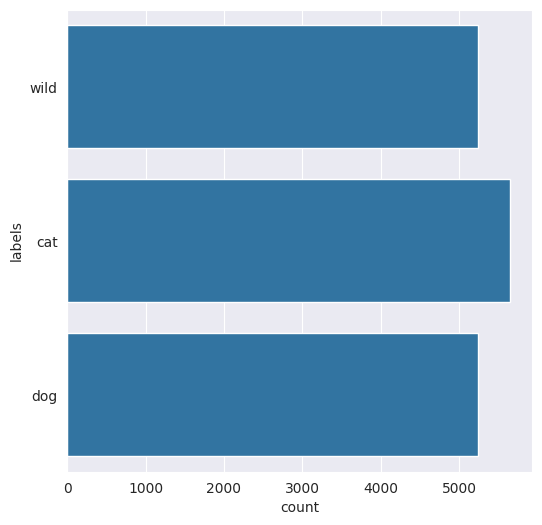

In [10]:
# Definisikan path sumber
lung_path = "afhq/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [11]:
mypath= 'afhq/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
cat,5653
dog,5239
wild,5238


In [12]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']


In [15]:
# Menyatukan ke dalam masing-masing dataframe
df_all = pd.DataFrame({'path':X,'labels':y,'set':'train'})

In [16]:
# Gabungkan DataFrame df_tr dan df_te
# df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "afhq/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels
train  cat       5653
       dog       5239
       wild      5238
dtype: int64 


                                           path labels    set
7754    afhq/dataset/cat/pixabay_cat_001943.jpg    cat  train
13964    afhq/dataset/dog/flickr_dog_000555.jpg    dog  train
2234   afhq/dataset/wild/flickr_wild_001890.jpg   wild  train
5938    afhq/dataset/cat/pixabay_cat_002055.jpg    cat  train
13005   afhq/dataset/dog/pixabay_dog_001108.jpg    dog  train


In [17]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [18]:
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"

train_cat = os.path.join(TRAIN_DIR + '/cat')
train_dog = os.path.join(TRAIN_DIR + '/dog')
train_wild = os.path.join(TRAIN_DIR + '/wild')


print("Total number of cat images in training set: ",len(os.listdir(train_cat)))
print("Total number of dog images in training set: ",len(os.listdir(train_dog)))
print("Total number of wild images in training set: ",len(os.listdir(train_wild)))


Total number of cat images in training set:  5653
Total number of dog images in training set:  5239
Total number of wild images in training set:  5238


In [19]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2,
                             rotation_range=20,  # Rotate images by up to 20 degrees
                             width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
                             height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
                             shear_range=0.2,  # Apply shear transformations
                             zoom_range=0.3,  # Zoom in or out on images
                             horizontal_flip=True  # Flip images horizontally
                             )
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

Found 12906 images belonging to 3 classes.
Found 3224 images belonging to 3 classes.


## Modelling

In [20]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_test = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_test.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_test.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_test.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_test.add(BatchNormalization())
model_test.add(MaxPool2D((2, 2)))

# Flatten layer
model_test.add(Flatten())
# 1nd Dense Layer
model_test.add(Dense(256, activation = 'relu'))
# 1nd Dropout Layer
model_test.add(Dropout(0.5))
# 2nd Dense Layer
model_test.add(Dense(128, activation = 'relu'))
# 2nd Dropout Layer
model_test.add(Dropout(0.3))
# 3nd Dense Layer
model_test.add(Dense(64, activation = 'relu'))

# Final Dense layer
model_test.add(Dense(3, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_test.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the Model Architecture
print(model_test.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,763,139 (10.54 MB)

 Trainable params: 2,762,947 (10.54 MB)

 Non-trainable params: 192 (768.00 B)

None


In [21]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
train_cat = os.path.join(TRAIN_DIR + '/cat')
train_dog = os.path.join(TRAIN_DIR + '/dog')
train_wild = os.path.join(TRAIN_DIR + '/wild')

# Calculate class weights for three classes
count_cat, count_dog, count_wild = len(os.listdir(train_cat)), len(os.listdir(train_dog)), len(os.listdir(train_wild))
total_samples = count_cat + count_dog + count_wild

weight_cat = (1 / count_cat) * (total_samples) / 3.0
weight_dog = (1 / count_dog) * (total_samples) / 3.0
weight_wild = (1 / count_wild) * (total_samples) / 3.0

class_weights = {0: weight_cat, 1: weight_dog, 2: weight_wild}  # Assuming 0:cat, 1:dog, 2:wild

# Fitting / training model
history_1 = model_test.fit(train_generator,
                        epochs=40,
                        batch_size=24,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[checkpoint, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4415 - loss: 1.5798

404/404 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - accuracy: 0.4417 - loss: 1.5789 - val_accuracy: 0.4150 - val_loss: 1.1248
Epoch 2/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6261 - loss: 0.8121

404/404 ━━━━━━━━━━━━━━━━━━━━ 72s 178ms/step - accuracy: 0.6262 - loss: 0.8119 - val_accuracy: 0.6247 - val_loss: 0.8277
Epoch 3/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7943 - loss: 0.5212

404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 162ms/step - accuracy: 0.7944 - loss: 0.5211 - val_accuracy: 0.6486 - val_loss: 0.7708
Epoch 4/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8714 - loss: 0.3489

404/404 ━━━━━━━━━━━━━━━━━━━━ 73s 180ms/step - accuracy: 0.8714 - loss: 0.3489 - val_accuracy: 0.7460 - val_loss: 0.6036
Epoch 5/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8939 - loss: 0.2839

404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.8939 - loss: 0.2838 - val_accuracy: 0.8344 - val_loss: 0.4063
Epoch 6/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9207 - loss: 0.2256

404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 162ms/step - accuracy: 0.9207 - loss: 0.2256 - val_accuracy: 0.8766 - val_loss: 0.3458
Epoch 7/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9315 - loss: 0.2004

404/404 ━━━━━━━━━━━━━━━━━━━━ 63s 157ms/step - accuracy: 0.9315 - loss: 0.2004 - val_accuracy: 0.9001 - val_loss: 0.2516
Epoch 8/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 158ms/step - accuracy: 0.9344 - loss: 0.1844 - val_accuracy: 0.8865 - val_loss: 0.2860
Epoch 9/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.9452 - loss: 0.1577 - val_accuracy: 0.8462 - val_loss: 0.3594
Epoch 10/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 160ms/step - accuracy: 0.9455 - loss: 0.1535 - val_accuracy: 0.8719 - val_loss: 0.3177
Epoch 11/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9531 - loss: 0.1439

404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 160ms/step - accuracy: 0.9531 - loss: 0.1439 - val_accuracy: 0.9215 - val_loss: 0.2058
Epoch 12/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 74s 183ms/step - accuracy: 0.9582 - loss: 0.1212 - val_accuracy: 0.8676 - val_loss: 0.4198
Epoch 13/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 66s 165ms/step - accuracy: 0.9529 - loss: 0.1345 - val_accuracy: 0.8133 - val_loss: 0.4550
Epoch 14/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9548 - loss: 0.1320

404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - accuracy: 0.9549 - loss: 0.1319 - val_accuracy: 0.9482 - val_loss: 0.1423
Epoch 15/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 159ms/step - accuracy: 0.9602 - loss: 0.1197 - val_accuracy: 0.9522 - val_loss: 0.1578
Epoch 16/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 67s 165ms/step - accuracy: 0.9676 - loss: 0.0961 - val_accuracy: 0.8945 - val_loss: 0.2324
Epoch 17/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 66s 164ms/step - accuracy: 0.9625 - loss: 0.1206 - val_accuracy: 0.8747 - val_loss: 0.2988
Epoch 18/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.9630 - loss: 0.1074 - val_accuracy: 0.8787 - val_loss: 0.3069
Epoch 19/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.9622 - loss: 0.1072 - val_accuracy: 0.9439 - val_loss: 0.1592
Epoch 20/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 67s 165ms/step - accuracy: 0.9687 - loss: 0.0971 - val_accuracy: 0.8890 - val_loss: 0.2618
Epoch 21/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9647 - loss: 0.1195

404/404 ━━━━━━━━━━━━━━━━━━━━ 66s 164ms/step - accuracy: 0.9647 - loss: 0.1195 - val_accuracy: 0.9507 - val_loss: 0.1412
Epoch 22/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 73s 181ms/step - accuracy: 0.9674 - loss: 0.0957 - val_accuracy: 0.8499 - val_loss: 0.3940
Epoch 23/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 74s 184ms/step - accuracy: 0.9667 - loss: 0.1063 - val_accuracy: 0.8759 - val_loss: 0.4075
Epoch 24/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 73s 182ms/step - accuracy: 0.9725 - loss: 0.0843 - val_accuracy: 0.9014 - val_loss: 0.3062
Epoch 25/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9719 - loss: 0.0876

404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.9719 - loss: 0.0876 - val_accuracy: 0.9606 - val_loss: 0.1136
Epoch 26/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 63s 157ms/step - accuracy: 0.9715 - loss: 0.0868 - val_accuracy: 0.9504 - val_loss: 0.1322
Epoch 27/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - accuracy: 0.9736 - loss: 0.0805 - val_accuracy: 0.9392 - val_loss: 0.1721
Epoch 28/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 158ms/step - accuracy: 0.9747 - loss: 0.0745 - val_accuracy: 0.9432 - val_loss: 0.1476
Epoch 29/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 74s 182ms/step - accuracy: 0.9737 - loss: 0.0787 - val_accuracy: 0.8824 - val_loss: 0.3457
Epoch 30/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 159ms/step - accuracy: 0.9740 - loss: 0.0741 - val_accuracy: 0.8961 - val_loss: 0.3339
Epoch 31/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 65s 161ms/step - accuracy: 0.9711 - loss: 0.0863 - val_accuracy: 0.8434 - val_loss: 0.6626
Epoch 32/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 63s 155ms/step - accuracy: 0.9745 - loss: 0.076

## Evaluasi dan Visualisasi

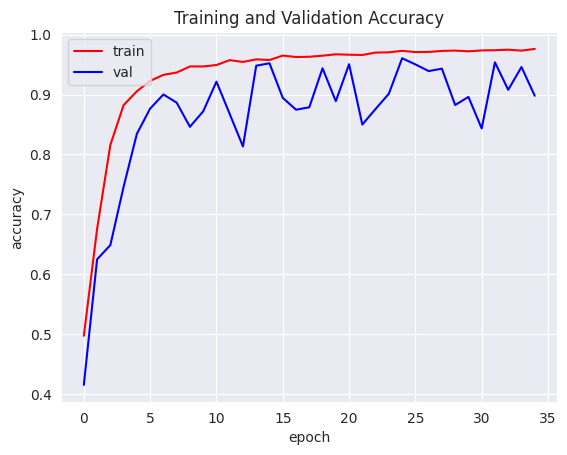

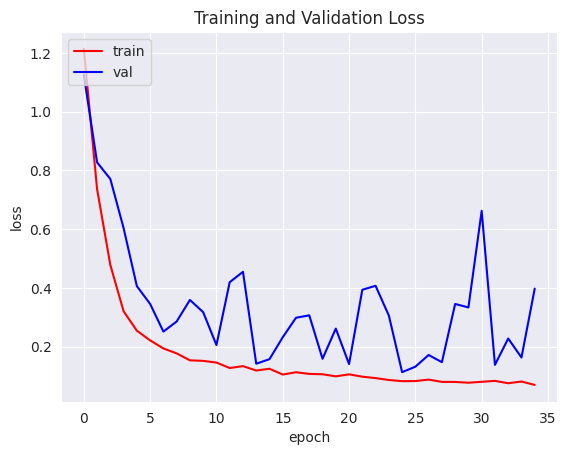

In [23]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

In [24]:
# model_test.save("model.h5")
# Install tensorflowjs
!pip install tensorflowjs

# Convert model.h5 to model
!tensorflowjs_converter --input_format=keras best_model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 117.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
2025-02-11 11:57:36.772571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739275056.792921   12346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739275056.799222   12346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS 

In [25]:
export_dir = 'saved_model/'
tf.saved_model.save(model_test, export_dir)

# Convert SavedModel menjadi model.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

17204

In [26]:
from PIL import Image
import os

def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution(combined_dir)

wild: 5238
- (512, 512)
---------------
cat: 5653
- (512, 512)
---------------
dog: 5239
- (512, 512)
---------------

Total: 16130


## Inference (Optional)

In [27]:
# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

def predict_image(image_path):
    # Use tf.keras.utils.load_img instead of image.load_img
    img = tf.keras.utils.load_img(image_path, target_size=(150, 150), color_mode="grayscale")
    img_array = tf.keras.utils.img_to_array(img)  # Use tf.keras.utils.img_to_array
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    class_labels = {0: 'cat', 1: 'dog', 2: 'wild'} # Replace with your actual class labels
    predicted_label = class_labels.get(predicted_class, "Unknown")

    return predicted_label, prediction


# Example usage
image_path = "New_Cat_Data.jpg" # Replace with the path to your image
predicted_label, prediction = predict_image(image_path)
print(f"Predicted label: {predicted_label}")
print(f"Prediction probabilities: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
Predicted label: cat
Prediction probabilities: [[1.000000e+00 2.292307e-16 1.343361e-13]]
